In [54]:
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist


In [4]:
pd.options.display.max_rows = 4000

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
train = pd.read_csv("data/feature_selection.csv")

In [7]:
train.head()

,ID,age,class,A.c1.1,A.c1.2,A.c1.3,A.c1.4,A.c1.5,A.c2.1,A.c2.2,...,J.c8.1,J.c8.2,J.c8.3,J.c8.4,J.c8.5,J.c9.1,J.c9.2,J.c9.3,J.c9.4,J.c9.5
0,5560,3,typ,2.238984,3.238984,4.238984,5.238984,6.238984,2.539386,3.539386,...,2.330630,3.330630,4.330630,5.330630,6.330630,0.105146,1.105146,2.105146,3.105146,4.105146
1,4694,3,typ,1.490947,2.490947,3.490947,4.490947,5.490947,0.692924,1.692924,...,0.033946,1.033946,2.033946,3.033946,4.033946,-0.921489,0.078511,1.078511,2.078511,3.078511
2,6449,3,typ,1.828413,2.828413,3.828413,4.828413,5.828413,2.995978,3.995978,...,-0.309544,0.690456,1.690456,2.690456,3.690456,1.838188,2.838188,3.838188,4.838188,5.838188
3,3008,3,asd,1.930039,2.930039,3.930039,4.930039,5.930039,2.698195,3.698195,...,0.727438,1.727438,2.727438,3.727438,4.727438,2.793029,5.793029,10.793029,17.793029,26.793029
4,3863,3,typ,2.272464,3.272464,4.272464,5.272464,6.272464,1.539144,2.539144,...,2.168858,3.168858,4.168858,5.168858,6.168858,-0.938000,0.062000,1.062000,2.062000,3.062000


In [42]:
train = train.drop(columns=["ID"])

In [8]:
train.columns

Index(['ID', 'age', 'class', 'A.c1.1', 'A.c1.2', 'A.c1.3', 'A.c1.4', 'A.c1.5',
       'A.c2.1', 'A.c2.2',
       ...
       'J.c8.1', 'J.c8.2', 'J.c8.3', 'J.c8.4', 'J.c8.5', 'J.c9.1', 'J.c9.2',
       'J.c9.3', 'J.c9.4', 'J.c9.5'],
      dtype='object', length=453)

In [12]:
train["class"].nunique()

2

In [22]:
train["age"].nunique()

1

In [24]:
c = train.corr().abs()


In [26]:
s = c.unstack()
so = s.sort_values(kind="quicksort")

In [35]:
so_r = so.tolist().reverse()

In [37]:
so_r

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=1, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Text(0.5, 0, 'k')

Text(0, 0.5, 'Distortion')

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

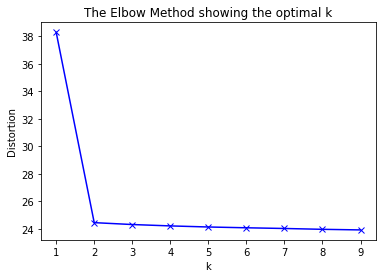

In [56]:
# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(train)
    kmeanModel.fit(train)
    distortions.append(sum(np.min(cdist(train, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / train.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [50]:
from sklearn import preprocessing
columns = train.drop(columns=["age", "class"]).columns
data_scaled = pd.DataFrame(preprocessing.scale(train),columns=columns) 


ValueError: Shape of passed values is (452, 818), indices imply (450, 818)

In [43]:
n_comp = 20
# PCA
print('\nRunning PCA ...')
pca = PCA(n_components=n_comp, svd_solver='full', random_state=1001)
X_pca = pca.fit_transform(train)
print('Explained variance: %.4f' % pca.explained_variance_ratio_.sum())

print('Individual variance contributions:')
for j in range(n_comp):
    print(pca.explained_variance_ratio_[j])


Running PCA ...
Explained variance: 0.7607
Individual variance contributions:
0.6505823239422619
0.00679280613473883
0.0067188394647161405
0.0064238160894044116
0.006308947550961055
0.006256404445298335
0.006131567807483036
0.005990237304697479
0.005921263074247178
0.005811792830596779
0.005712732760276005
0.0056412721541888415
0.005525150788592221
0.005420163271576534
0.005400917922997806
0.005358377830823923
0.005292661216405598
0.005232381998306785
0.005133887074944215
0.005045957561481618


In [40]:
pca.explained_variance_

array([7.11790349e+06, 1.10952731e+03, 1.15862281e+01, 1.14340030e+01,
       1.09466097e+01, 1.07625221e+01, 1.06712741e+01, 1.04475721e+01,
       1.02058899e+01, 1.01020446e+01, 9.91106445e+00, 9.72299337e+00,
       9.62312328e+00, 9.42623235e+00, 9.24659871e+00, 9.20436647e+00,
       9.12993773e+00, 9.02734602e+00, 8.87587732e+00, 8.75756918e+00])

In [44]:
pca.transform(train)

array([[-15.77588055,  -1.21299585,   4.44597336, ...,  -4.26585721,
          0.92038498,  -0.96698049],
       [-17.86759181,  -7.41035552,  -1.10186652, ...,  -2.55020905,
         -3.87011296,  -1.44902529],
       [-17.59692226,  -2.99055931,   2.7868292 , ...,  -0.1708841 ,
          0.45694314,   2.11635987],
       ...,
       [-19.77210209,   3.45945777,  -1.08719082, ...,   2.68376908,
         -3.06077349,   0.81157725],
       [-16.1994565 ,  -3.98345547,  -3.92122257, ...,  -0.19583062,
          2.65052975,   0.43181513],
       [-17.87172438,  -1.62450518,  -3.82933543, ...,   1.7414802 ,
         -2.7945231 ,   1.24346467]])

In [45]:
pca.components_

array([[-1.37931842e-18, -1.24206431e-02,  1.22548938e-03, ...,
         7.58420492e-02,  1.50365908e-01,  2.49731053e-01],
       [-1.01572053e-17,  7.14659874e-05, -3.11561999e-02, ...,
        -2.25551711e-03, -2.68431304e-03, -3.25604094e-03],
       [ 3.76396675e-17,  6.52640902e-04,  2.59850968e-02, ...,
         6.17784179e-02,  5.78625725e-02,  5.26414453e-02],
       ...,
       [ 3.45912833e-17,  1.15818654e-04, -3.32858768e-02, ...,
         6.51286381e-02,  6.44337262e-02,  6.35071769e-02],
       [-3.31073121e-16, -8.17407510e-04,  3.30423069e-02, ...,
        -1.29921431e-02, -8.08769803e-03, -1.54843795e-03],
       [-1.00010803e-15,  6.42220382e-04,  5.24362747e-02, ...,
         3.80382750e-02,  3.41849527e-02,  2.90471897e-02]])

In [9]:
import pandas as pd
import numpy as np
import random
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import FeatureAgglomeration

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge

from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
import pickle

import warnings
warnings.filterwarnings('ignore')

random.seed(1729)

In [14]:
y_train = train['y']
train = train.drop('y', axis=1)

for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values))
        train[c] = lbl.transform(list(train[c].values))

LabelEncoder()

In [16]:
n_comp = 12

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(train)

# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(train)

# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(train)

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_results_train = grp.fit_transform(train)

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
srp_results_train = srp.fit_transform(train)

# FAG
fag = FeatureAgglomeration(n_clusters=n_comp, linkage='ward')
fag_results_train = fag.fit_transform(train)


In [17]:
dim_reds = list()
train_pca = pd.DataFrame()
train_ica = pd.DataFrame()
train_tsvd = pd.DataFrame()
train_grp = pd.DataFrame()
train_srp = pd.DataFrame()
train_fag = pd.DataFrame()

for i in range(1, n_comp + 1):
    train_pca['pca_' + str(i)] = pca2_results_train[:, i - 1]

    train_ica['ica_' + str(i)] = ica2_results_train[:, i - 1]

    train_tsvd['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]

    train_grp['grp_' + str(i)] = grp_results_train[:, i - 1]

    train_srp['srp_' + str(i)] = srp_results_train[:, i - 1]

    train_fag['fag_' + str(i)] = fag_results_train[:, i - 1]
    
dim_reds.append(('pca', train_pca))
dim_reds.append(('ica', train_ica))
dim_reds.append(('tsvd', train_tsvd))
dim_reds.append(('grp', train_grp))
dim_reds.append(('srp', train_srp))
dim_reds.append(('fag', train_fag))

In [20]:
# creating the combination from the '7' sets of reduced components
combs = [combinations(dim_reds, i+1) for i in range(0, len(dim_reds))]

dr_scores = list()
for c1 in combs:
    for c2 in c1:   
        train_, test_, id_ = list(), list(), list()
        for k in c2:
            train_.append(k[1])
            id_.append(k[0])
               
        train_x = train.reset_index(drop=True)
        train_.append(train_x)
            
        train_ = pd.concat(train_, axis=1)
        model = RandomForestRegressor()

        model.fit(train_, y_train)
        c_score = r2_score(y_train, model.predict(train_))
        
        dr_scores.append((','.join(id_), c_score))

        

NameError: name 'y_train' is not defined

In [19]:
rf = RandomForestRegressor()